In [1]:
import numpy as np
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import ipywidgets as widgets
from IPython.display import display
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from klusta.kwik import KwikModel
from scipy import signal

import sys 
sys.path.append('/home/harison/UFPE/IC/src/ipy/classes/') 
import kwikfile as kf



class MicroMatrix:
    
    def __init__(self,V=None,Nx=70,Ny=200,kpath=None):
        """!  @brief 
    
        @author: Harison P B de Oliveira
        @date: 2018.May.25
        """
        if Nx<50 or Ny<190:
            print("Dimensions of the matrix smaller than the electrode dimensions.")
            return
        else:
            self.Nx=Nx
            self.Ny=Ny
            self.kwik_model=None
            self.kwikfile=None
            self.kpath=None
            if kpath is not None:
                self.kwik_model=KwikModel(kpath)
                self.kpath=kpath
                self.kwikfile=kf.KwikFile(kpath)
                self.geometry=np.matrix([np.flipud (self.kwik_model.channel_positions [:,0])
                                         ,np.flipud (self.kwik_model.channel_positions [:,1]) ])
                if V is None:
                    self.V=np.zeros((Ny,Nx,32))
                else:
                    if V.shape[0] is Nx and V.shape[1] is Ny:
                        self.V=V
                    else:
                        self.V=zeros((Ny,Nx,32))
                        warnings.warn('The dimensions of V were replaced by (Ny, Nx).', Warning)
            else:
                print("Enter a valid kpath.")
        
    def get_matrix(self,waves=None):
        """!  @brief Returns an array filled with the potentials of each site.
    
        Parameters:
        waves: Matrix 2D with dimension (10,32) containing the potential of each site.
        
        @author: Harison P B de Oliveira
        @date: 2018.May.25
        """
        #print(self.V.shape[2])
        if waves is not None:
            #print(max(self.geometry[1,:]))
            x_offset = (self.Nx-(np.max(self.geometry[0,:])-np.min(self.geometry[0,:])))/2
            y_offset = (self.Ny-(np.max(self.geometry[1,:])-np.min(self.geometry[1,:])))/2
            #print(x_offset,y_offset)
            #waves=waves.T
            print(waves.shape)
            for z in range(0,self.V.shape[2]):
                
                for ch in range (0,self.geometry.shape[1]):
                    x_i=self.geometry[0,ch]-5+x_offset
                    x_f=self.geometry[0,ch]+5+x_offset
                    y_i=self.geometry[1,ch]-8+y_offset
                    y_f=self.geometry[1,ch]+8+y_offset
                    #print(ch)
                    #print(x_i,x_f)
                    #print(y_i,y_f)
                    if x_i >=0 and y_i>=0:
                        self.V[y_i:y_f,x_i:x_f,z]=waves[ch,z]
                
                    #print(self.V)
            #plt.imshow(self.V[:,:,30])
            
            return self.V
        else:
            return None
        
                
    def calculus_for(self,waves=None,maxIter=100):
        """!  @brief Returns an array for each of the 32 intervals showing the potential distribution of the 
        microspace.
        
        Parameters:
        waves: Matrix 2D with dimension (10,32) containing the potential of each site.
        maxIter: Maximum number of iterations.
        
        @author: Harison P B de Oliveira
        @date: 2018.May.31
        """
        
        if waves is not None:
            #T=self.V
            #print(T.shape)
            print("Calculating the potential matrix for each time sample.")
            progress = widgets.IntProgress(min=0, description='Loading microseconds:',max=self.V.shape[2])
            display(progress)
            for instant in range(0,self.V.shape[2]):
            #instant=0
                #print(instant)
                for iteration in range(0, maxIter):
                    for i in range(1,self.V.shape[0]-1):
                        for j in range(1,self.V.shape[1]-1):
                            self.V[i,j,instant]=0.25 * (self.V[i+1][j][instant] + self.V[i-1][j][instant] 
                                                        + self.V[i][j+1][instant] + self.V[i][j-1][instant])
           
                progress.value += 1
            #print(self.V)
            return self.V ##
        else:
            print("The waves vector is empty.")
            return None
        
    def get_animated_gif(self,waves=None,maxIter=500,group_name=None,cluster_id=None,interval=1,dpi=20):
        """!  @brief It generates an animated gif showing the microtemporal and microspace potential distruction.
        
        Parameters:
        waves: Matrix 2D with dimension (10,32) containing the potential of each site.
        maxIter: Maximum number of iterations.
        group_name: Name of the group from which the potentials were obtained.
        cluster_id: Name of the cluster from which the potentials were obtained.
        interval: Interval between each frame of the animated gif.
        dpi: Dots per inch of animated gif.
        
        @author: Harison P B de Oliveira
        @date: 2018.May.31
        """
          
        self.get_matrix(waves=waves)
        self.calculus_while(waves,maxIter)
        #c=np.load("waves.npy")
        #self.V=c
        fig=plt.figure(figsize=(7,20))
        colorinterpolation = 100

        def update(i):
            if i<32:
                plt.contourf(np.negative(self.V[:,:,i]),colorinterpolation, cmap=mpl.cm.jet,
                             vmin=np.min(self.V),vmax=np.max(self.V))
            else:
                img=self.V[:,:,0]
                img[:,:]=0
                plt.contourf(img[:,:],cmap=mpl.cm.gray)

            plt.axes().set_aspect('equal')
            #plt.
            plt.axis('tight')

        anim = FuncAnimation(fig, update, frames=np.arange(0, 33), interval=interval)
        name='imagens/group name/'+str(group_name)+"_"+str(cluster_id)+".gif"
        anim.save(name, dpi=dpi, writer='imagemagick')
        plt.close() 
        print("Animated GIF completed!")
        
        
        
    #desenvolvendo
    def calculus_while(self,waves=None,maxIter=100):
        """!  @brief Returns an array for each of the 32 intervals showing the potential distribution of the 
        microspace.
        
        Parameters:
        waves: Matrix 2D with dimension (10,32) containing the potential of each site.
        maxIter: Maximum number of iterations.
        
        @author: Harison P B de Oliveira
        @date: 2018.May.31
        """
        
        if waves is not None:
            #T=self.V
            #print(T.shape)
            print("Calculating the potential matrix for each time sample.")
            progress = widgets.IntProgress(min=0, description='Loading microseconds:',max=self.V.shape[2])
            display(progress)
            for instant in range(0,self.V.shape[2]):
            #instant=0
                #print(instant)
                #for iteration in range(0, maxIter):
                cor=10
                while cor >= 1:
                    
                    aux=self.V[:,:,instant]
                    for i in range(1,self.V.shape[0]-1):
                        for j in range(1,self.V.shape[1]-1):
                            self.V[i,j,instant]=0.25 * (self.V[i+1][j][instant] + self.V[i-1][j][instant] 
                                                        + self.V[i][j+1][instant] + self.V[i][j-1][instant])
                    #cor = np.max(signal.correlate2d (self.V[:,:,instant], aux))
                    #cor=np.corrcoef(self.V[:,:,instant], aux)
                    cor=np.correlate(self.V[:,:,instant], aux,mode='full')
                    print(cor)
                progress.value += 1
            #print(self.V)
            return self.V ##
        else:
            print("The waves vector is empty.")
            return None
            
    #testando
    def all_spikes_cluster(self,cluster_id=None):
        """!  @brief Returns an array with all the waveforms of a cluster.
        
        @author: Harison P B de Oliveira
        @date: 2018.Jun.15
        """
        if cluster_id is not None:
            if not(cluster_id in self.all_clusters()):
                raise ValueError("\nThis cluster was not found in kwik file: %s\n" % cluster_id)
            spk_id=self.kwikfile.all_spike_id_on_cluster(cluster_id=cluster_id)
            w=kwik_model.all_waveforms
            wf=w[spk_id]
            
            return wf
    
    #testando
    def amplitudes_spike_id(self,group_name=None,spk_id=None):
        """!  @brief Returns the waveform of a list of spikes id.
        
        @author: Harison P B de Oliveira
        @date: 2018.Jun.15
        """
        
        w=self.kwik_model.all_waveforms
        if spk_id is None and group_name is not None:
            spk_id=self.kwikfile.all_spike_id_on_groups(group_name=group_name)
        else:
            raise ValueError("\nReport a valid group_name.\n")
        wf=w[spk_id]    
        return wf
        
    #testando
    def set_animated_gif(self,spk_id=None,maxIter=500,group_name=None,cluster_id=None,interval=1,dpi=20):
        
        if group_name and cluster_id is not None:
            w=self.kwik_model.all_waveforms
            if spk_id is None:
                spk_id=self.kwikfile.all_spike_id_on_groups(group_name=group_name)
                wf=w
            else:
                wf=w[spk_id]
            print(wf.shape)
            for i in range(0,wf.shape[0]):
                waves=wf[i,:,:]
                self.get_animated_gif(waves=waves.T,maxIter=maxIter,group_name=group_name,cluster_id=cluster_id
                                                                                      ,interval=interval,dpi=dpi)

In [5]:
import sys 
sys.path.append('/home/harison/UFPE/IC/src/ipy/classes/') 
import kwikfile as kf

help (kf.KwikFile.spikes_on_cluster)

Help on function spikes_on_cluster in module kwikfile:

spikes_on_cluster(self, cluster_id)
    ! @brief Returns the all spike samples within a single cluster
    
    Parameters:
    cluster_id: id used to indentify the cluster.
    
    Author: Nivaldo A P de Vasconcelos
    Date: 2018.Feb.02



In [2]:
kpath="/home/harison/UFPE/data/g01.kwik"
mm=MicroMatrix(kpath=kpath)

Created class on = /home/harison/UFPE/data/g01.kwik !


###########################################################################

In [15]:
kwikfile=kf.KwikFile(kpath)
spk_id=kwikfile.all_spike_id_on_cluster(cluster_id=6)
print(spk_id[0])

Created class on = /home/harison/UFPE/data/g01.kwik !
757


In [16]:
mm.set_animated_gif(spk_id=spk_id[0],group_name='good',cluster_id=6)

(1, 32, 10)
(10, 32)
Calculating the potential matrix for each time sample.


/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IntProgress(value=0, description='Loading microseconds:', max=32)

ValueError: object too deep for desired array

In [14]:
a=mm.amplitudes_spike_id(spk_id=spk_id[0])

ValueError: 
Report a valid group_name.


In [92]:
#b=a[0,:,:]
#print(b)
c=a.T
#print(c.shape)

In [93]:
#a=mm.get_matrix(waves)
mm.get_animated_gif(waves=c,group_name="good",cluster_id="6")

32
(10, 32)
Calculating the potential matrix for each time sample.


/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/ipykernel_launcher.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IntProgress(value=0, description='Loading microseconds:', max=32)

[[[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.00664542  0.01118697  0.00140549 ...,  0.0114561   0.01323683
    0.01975298]
  [ 0.01325447  0.02232631  0.00281549 ...,  0.0228843   0.02643846
    0.03945405]
  ..., 
  [ 0.01264263  0.024645    0.00692702 ...,  0.03302119  0.03726605
    0.05349089]
  [ 0.00632323  0.01232652  0.00346615 ...,  0.0165183   0.01864443
    0.02676032]
  [ 0.          0.          0.         ...,  0.          0.          0.        

In [4]:
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider, Text
import ipywidgets as widgets
import kwikfile as kf
from klusta.kwik import KwikModel

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='center'
)

data = [
    Box([Label(value='Path'),
            Text("/home/harison/UFPE/data/g01.kwik")
            ], layout=form_item_layout),
    Box([Label(value='Group name:'),
         Dropdown(options=['good', 'mua', 'noise'])],layout=form_item_layout)
    
]

form = Box(data, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='50%'
))

display(form)

button = widgets.Button(description="Enviar nome do grupo e diretório.")
display(button)

def on_button_clicked(b):
    #kpath=form_items[0].children[0].value
    kpath=data[0].children[1].value
    group_name=data[1].children[1].value
    
    kw=kf.KwikFile(kpath)
    km=KwikModel(kpath)
    clusters=kw.clusters (group_name=group_name)
    
    data_2 = [
        Box([Label(value='Cluster_id:'),
             Dropdown(options=clusters)],layout=form_item_layout)   
    ]
    
    form_2 = Box(data_2, layout=Layout(
        display='flex',
        flex_flow='column',
        border='solid 2px',
        align_items='stretch',
        width='50%'
    ))
    
    display(form_2)
    button = widgets.Button(description="Enviar id do cluster.")
    display(button)
    
    
    def on_button_clicked(b):
        cluster_id=data_2[0].children[1].value
        #waves=np.zeros((10,32))
        print("Obtaining the amplitudes of the 32 samples for each channel of the cluster.")
        #clusters = km.spike_clusters
        #idx=np.argwhere (clusters==cluster_id)
        #w=km.all_waveforms[idx]
        #num_channels = w.shape[2]
        #for ch in range (0,num_channels):
         #   waves[ch,:]+=np.mean(w[:,:,ch],0)
            
        print("Generating the 3D matrix for the potentials.")   
        mm = MicroMatrix(kpath=kpath)    
        #a=mm.get_matrix(waves)
        
        print("Generating animated gif.")
        mm.get_animated_gif(waves=waves,maxIter=500,group_name=group_name,cluster_id=cluster_id,interval=300,dpi=80)
        
    button.on_click(on_button_clicked)
    
    
button.on_click(on_button_clicked)

Box(children=(Box(children=(Label(value='Path'), Text(value='/home/harison/UFPE/data/g01.kwik')), layout=Layout(display='flex', flex_flow='row', justify_content='center')), Box(children=(Label(value='Group name:'), Dropdown(options=('good', 'mua', 'noise'), value='good')), layout=Layout(display='flex', flex_flow='row', justify_content='center'))), layout=Layout(align_items='stretch', border='solid 2px', display='flex', flex_flow='column', width='50%'))

Button(description='Enviar nome do grupo e diretório.', style=ButtonStyle())

In [13]:
mm  = MicroMatrix(geometry=geometry)
a=mm.get_matrix(waves)

32


/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
import numpy as np
c=np.load("waves.npy")

In [15]:
mm.get_animated_gif(waves=c,maxIter=500,group_name="good",cluster_id=10,interval=300,dpi=150)

In [4]:
c=mm.calculus(waves=waves)
c.shape

IntProgress(value=0, description='Loading microseconds:', max=32)

KeyboardInterrupt: 

/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/animation.py:782: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


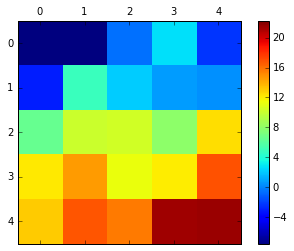

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

def generate_data():
    a = np.arange(25).reshape(5, 5)
    b = 10 * np.random.rand(5, 5)
    return a - b 

def update(data):
    mat.set_data(data)
    return mat 

def data_gen():
    while True:
        yield generate_data()

fig, ax = plt.subplots()
mat = ax.matshow(generate_data())
plt.colorbar(mat)
ani = animation.FuncAnimation(fig, update, data_gen, interval=500,
                              save_count=50)
ani.save('animation.gif')

In [4]:
import numpy as np
#from tempfile import TemporaryFile
#outfile = TemporaryFile()
#x = np.arange(10)
#np.save(outfile, x)
#np.savetxt('good.out', good) 
np.save("waves",c)
#g = np.loadtxt('good.out')
#m = np.loadtxt('mua.out')


NameError: name 'c' is not defined

In [7]:
np.min(c)
np.max(c)

362.95751762228866

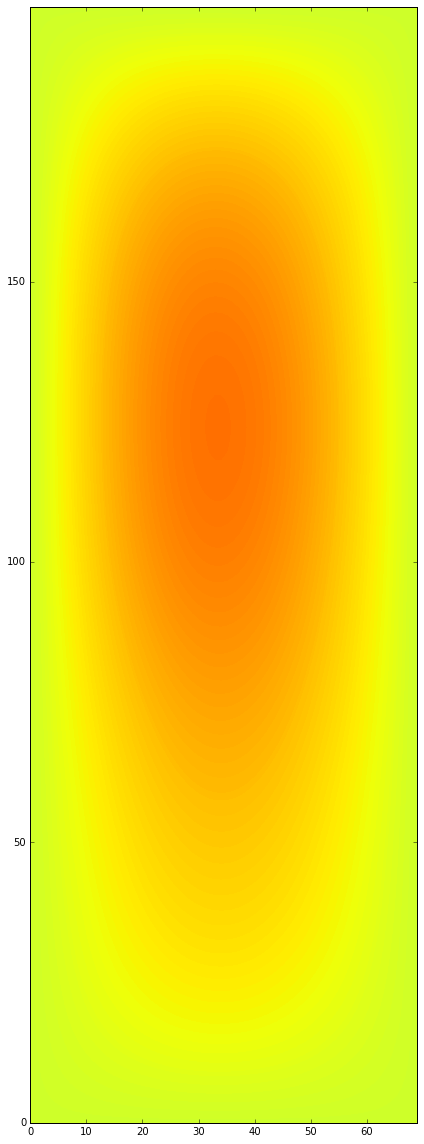

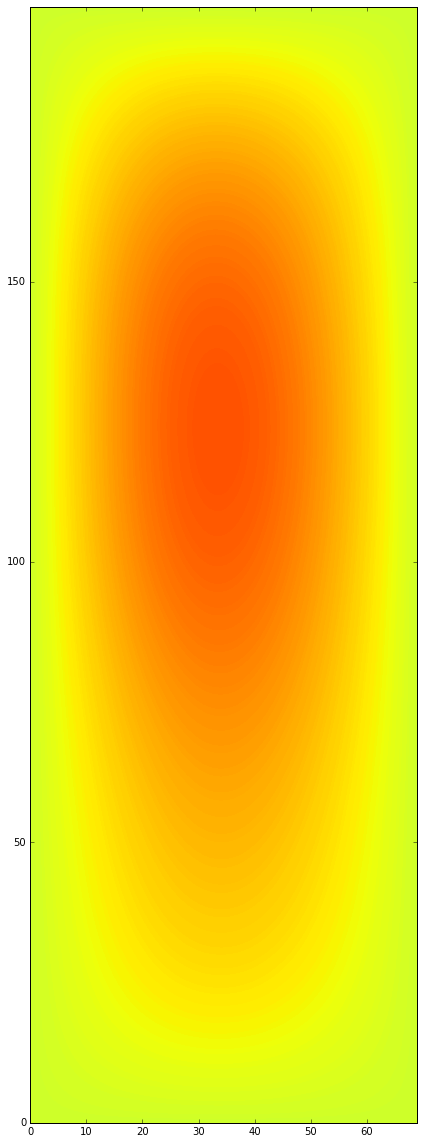

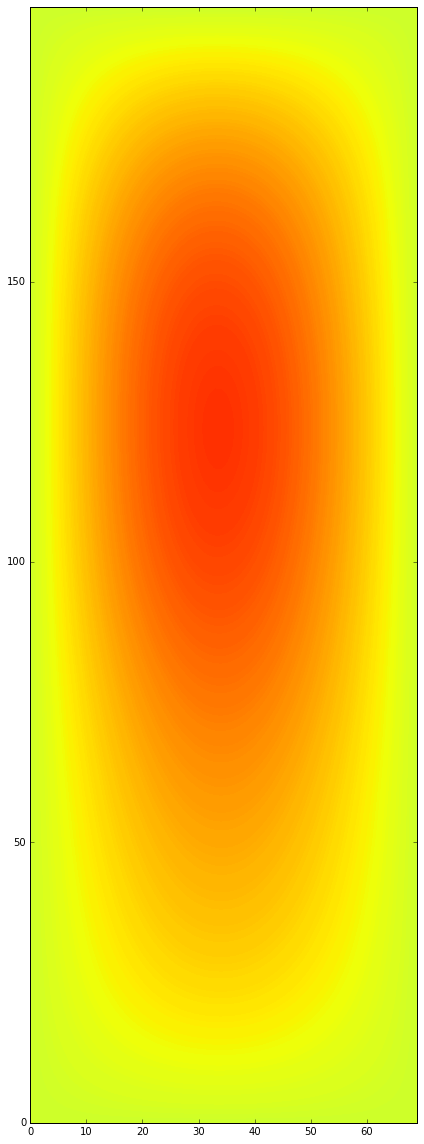

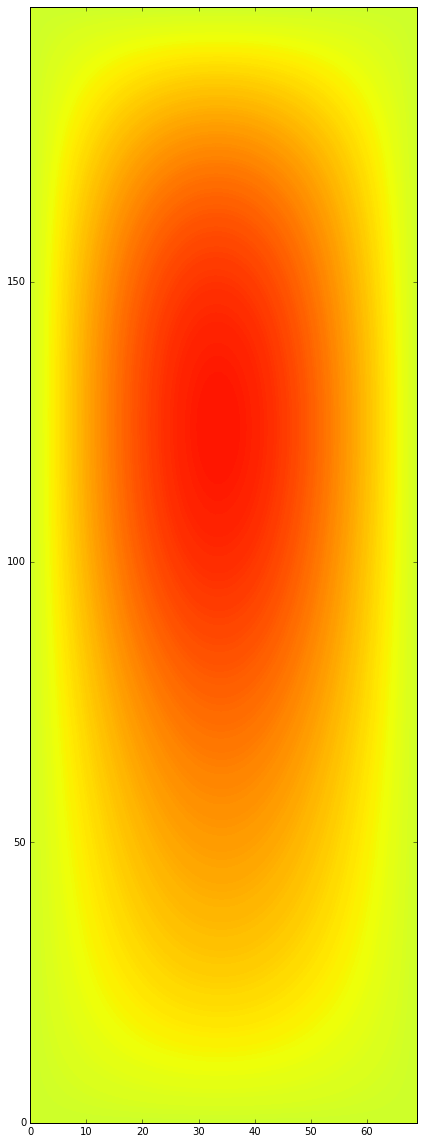

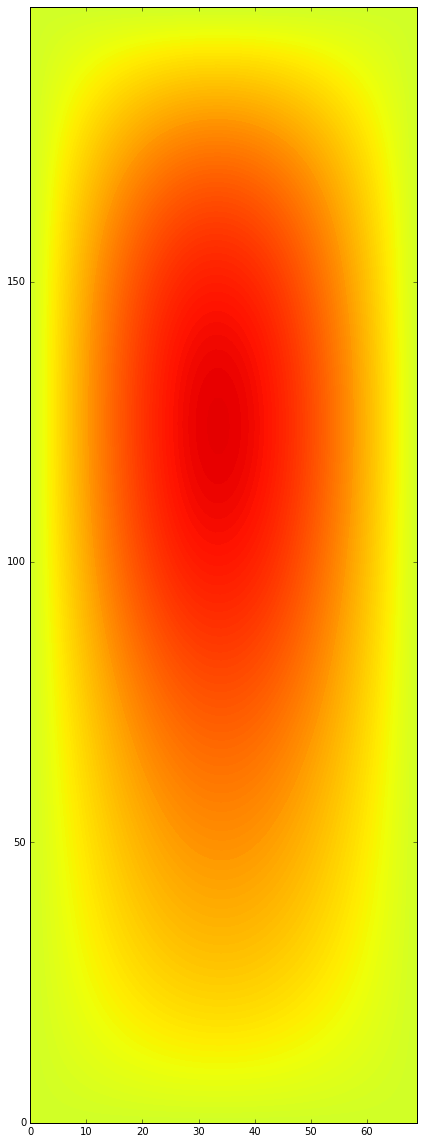

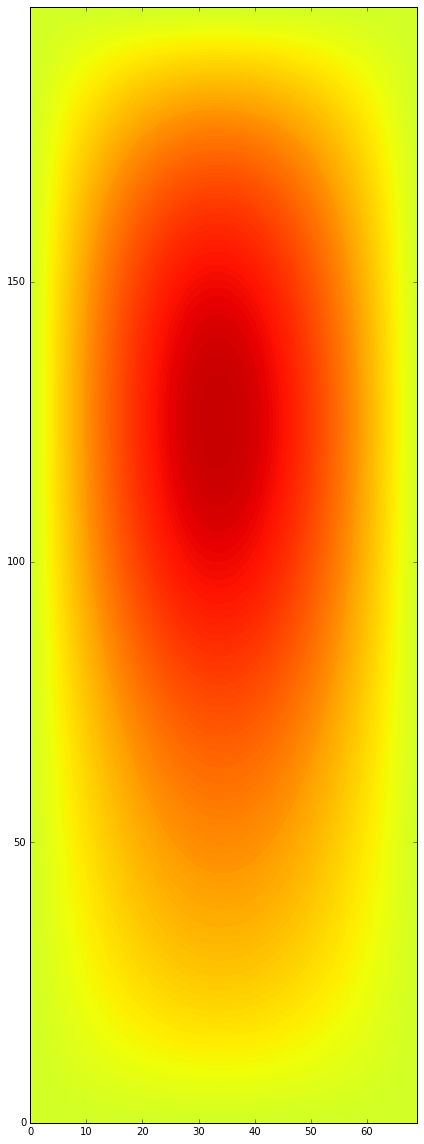

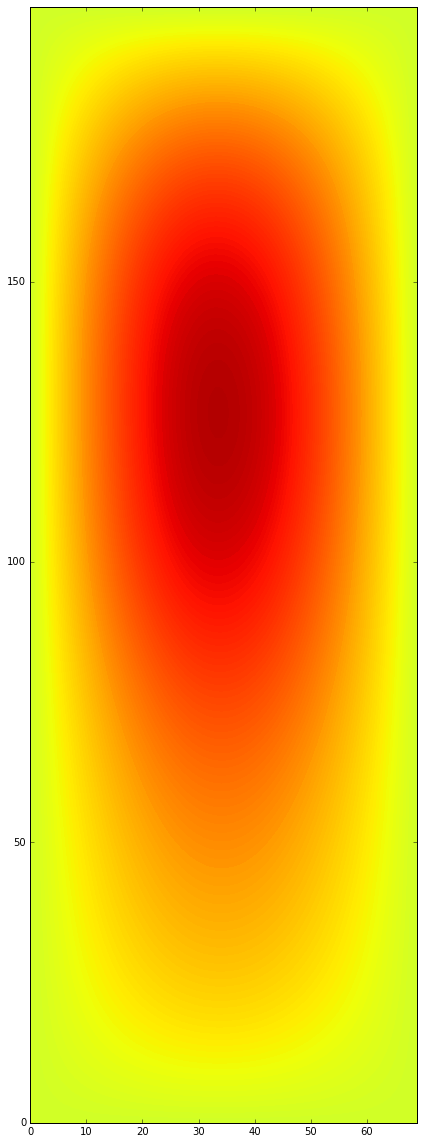

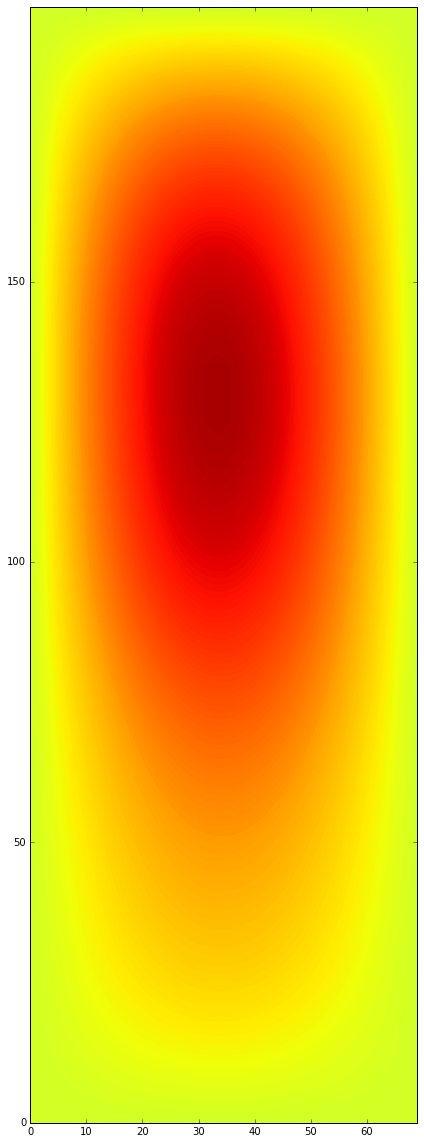

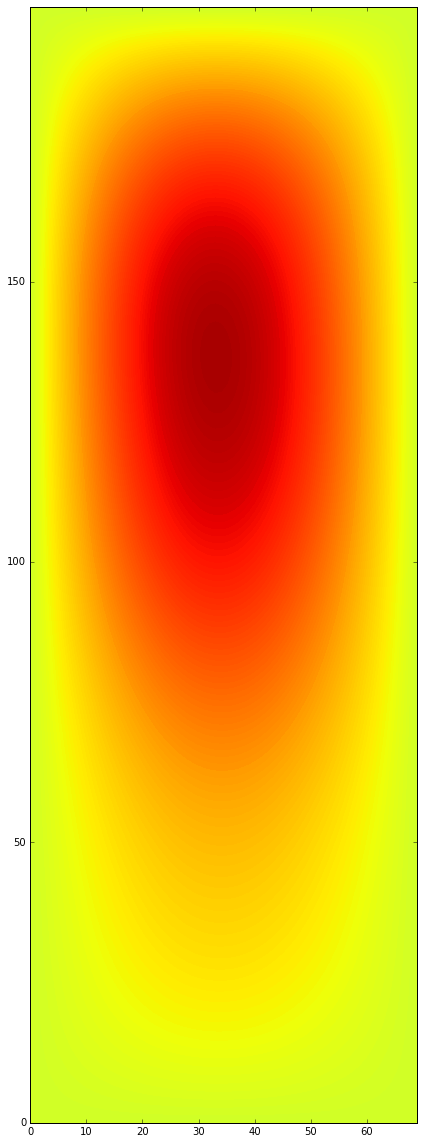

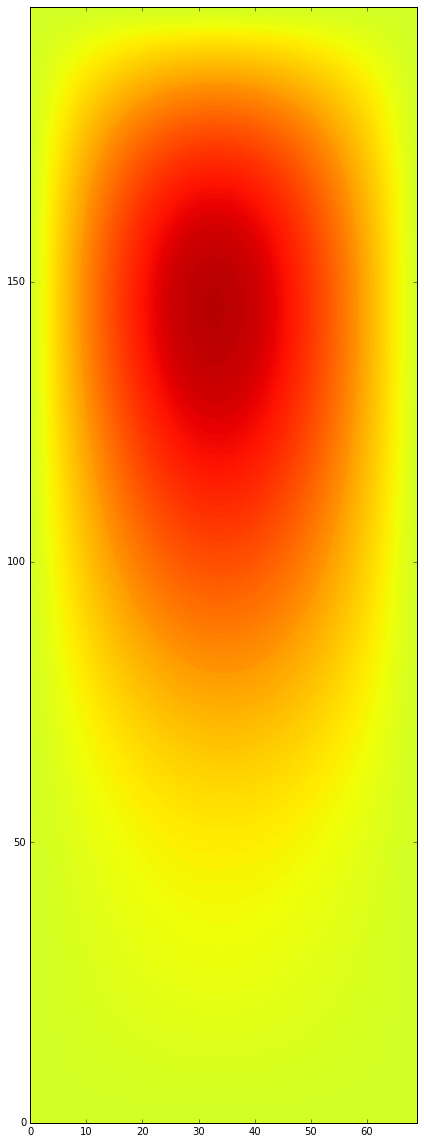

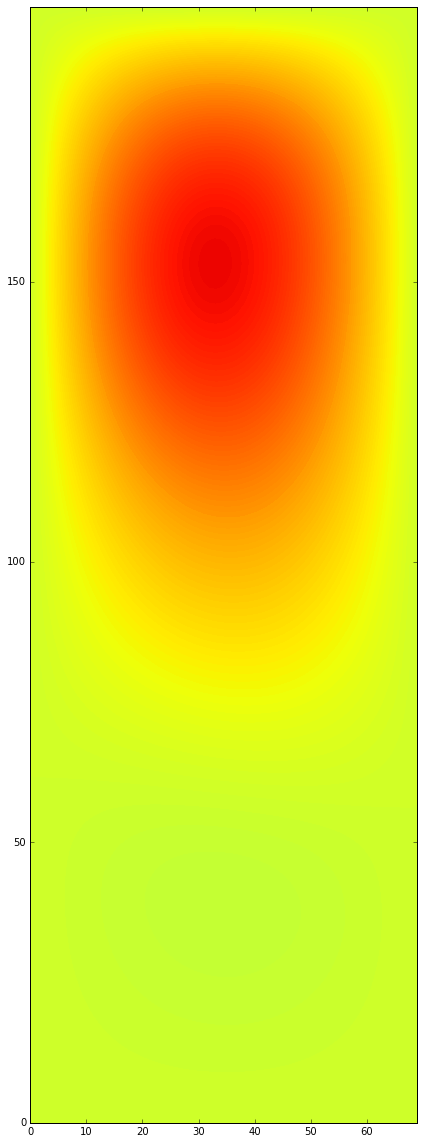

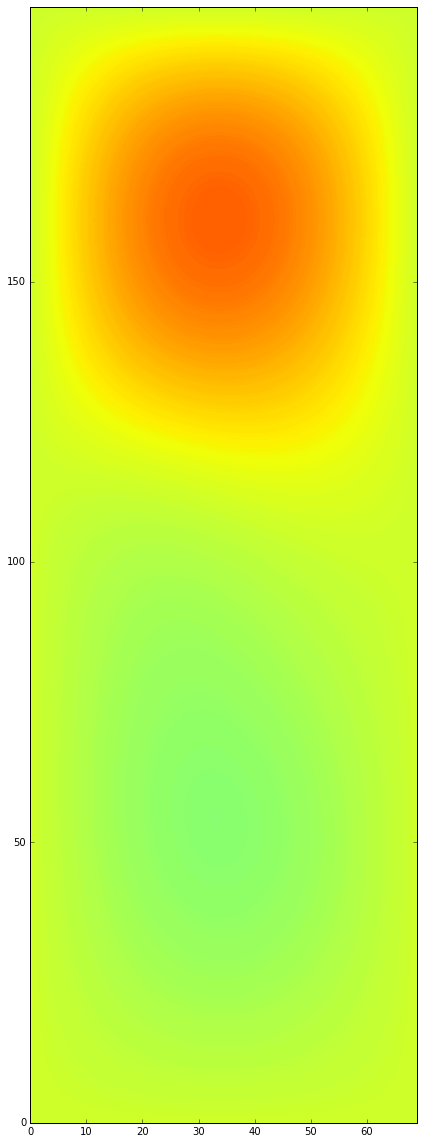

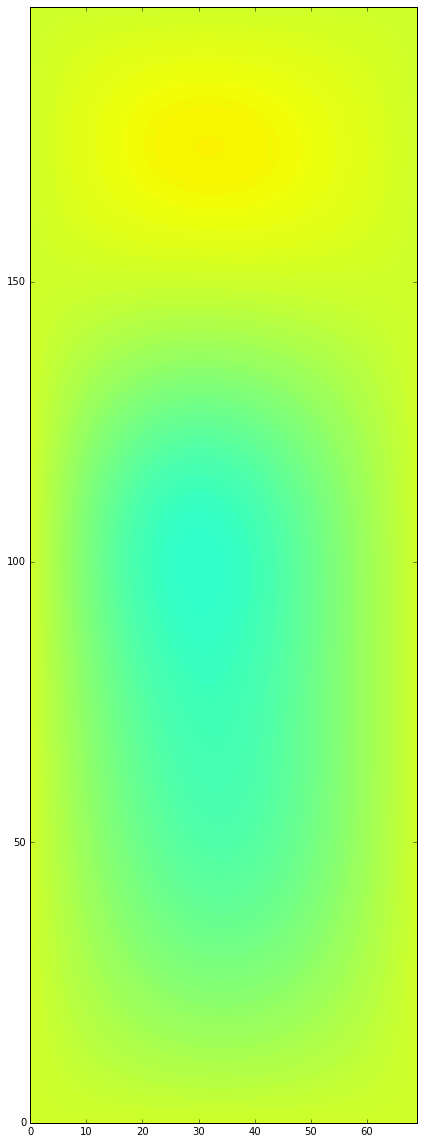

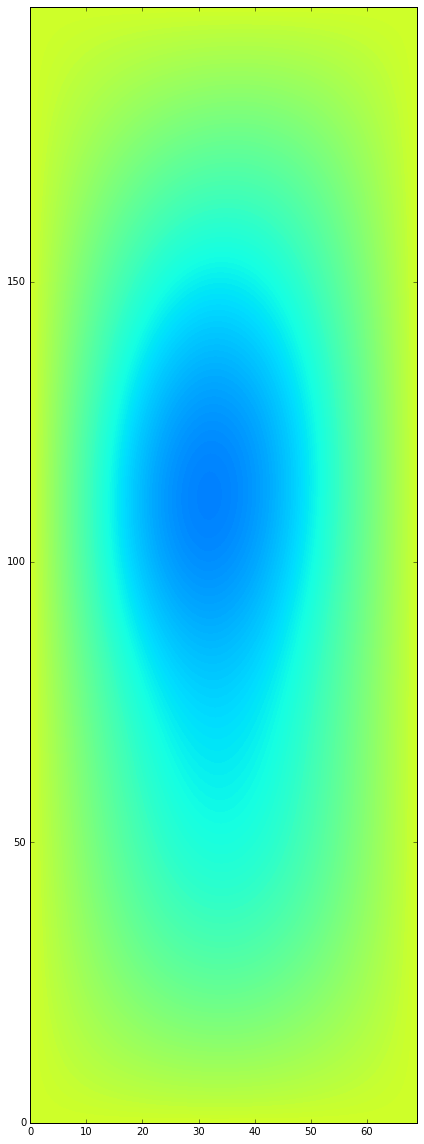

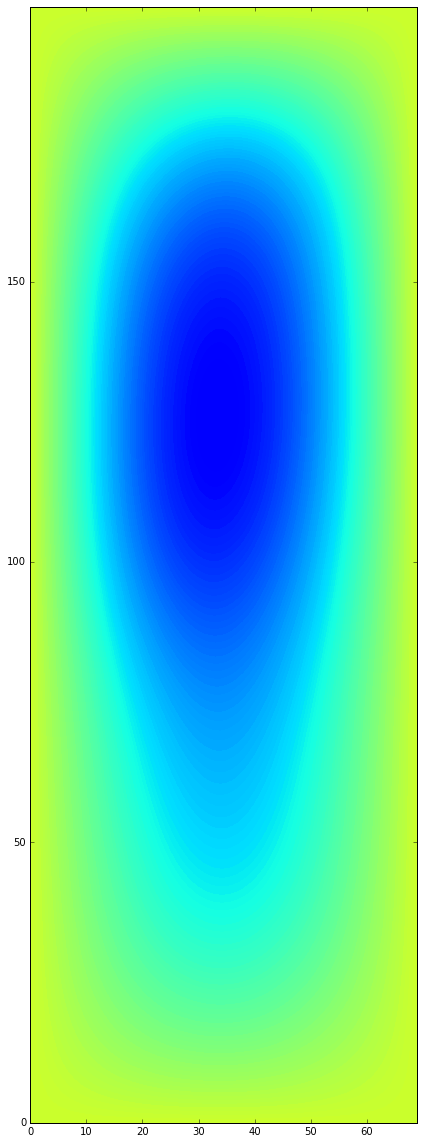

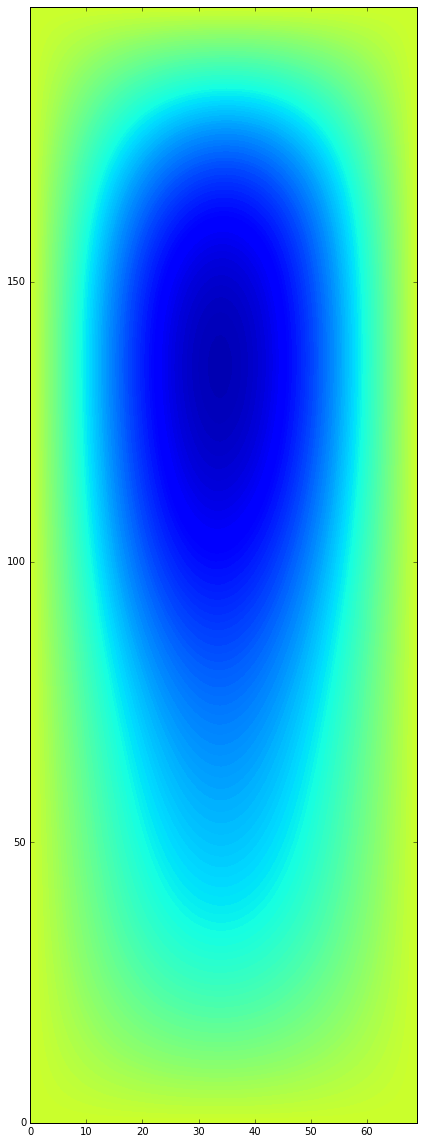

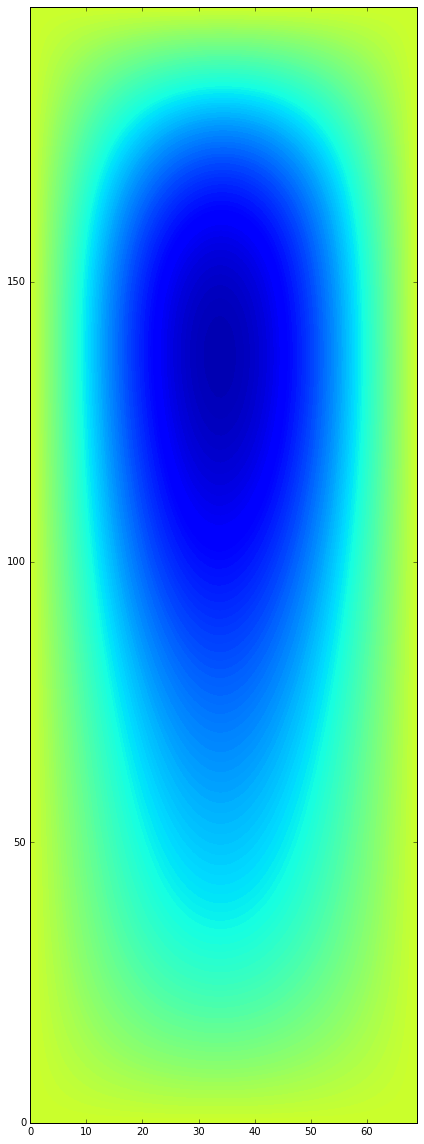

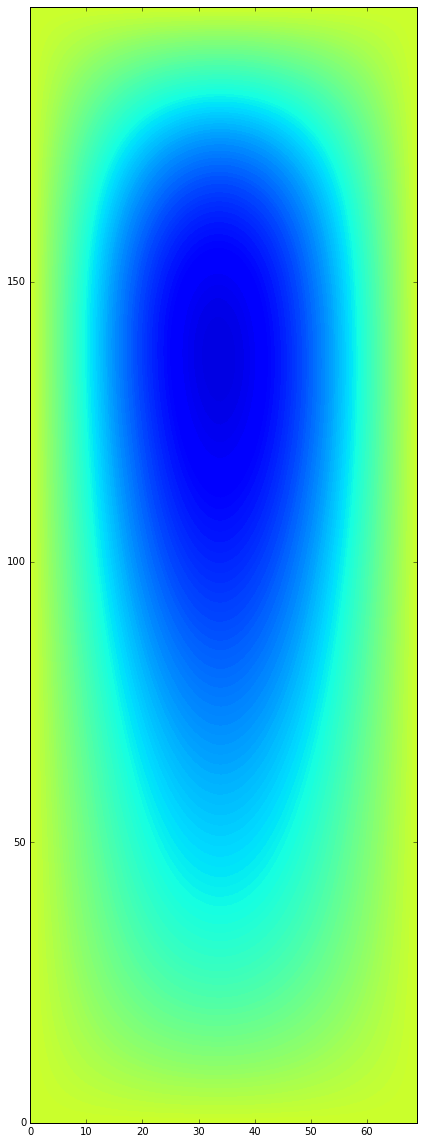

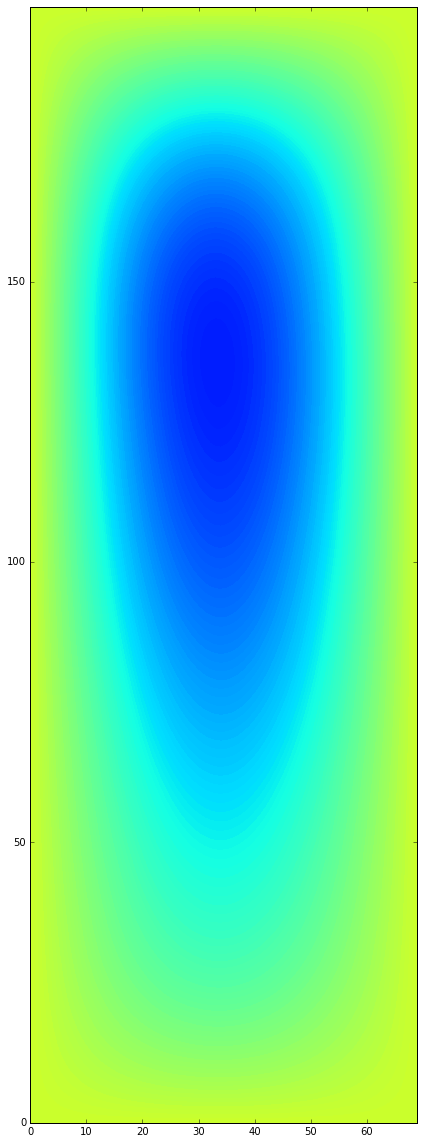

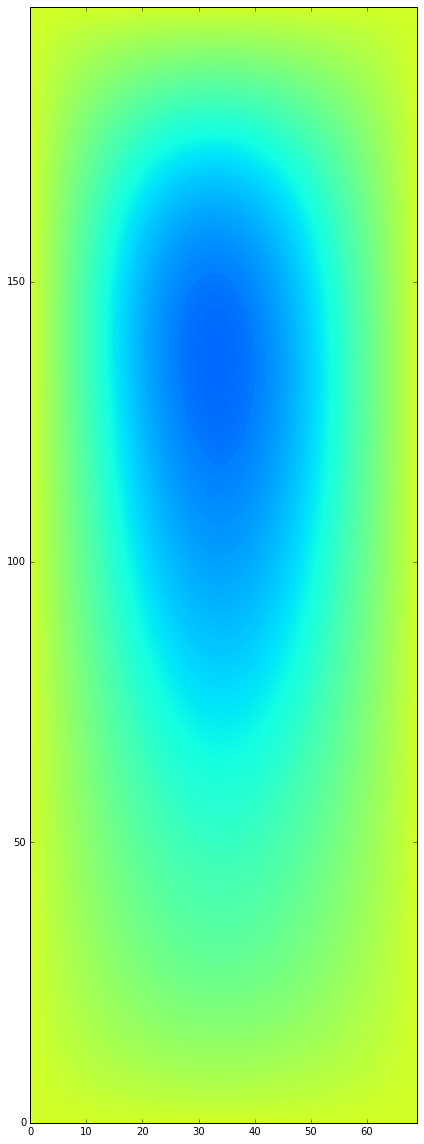

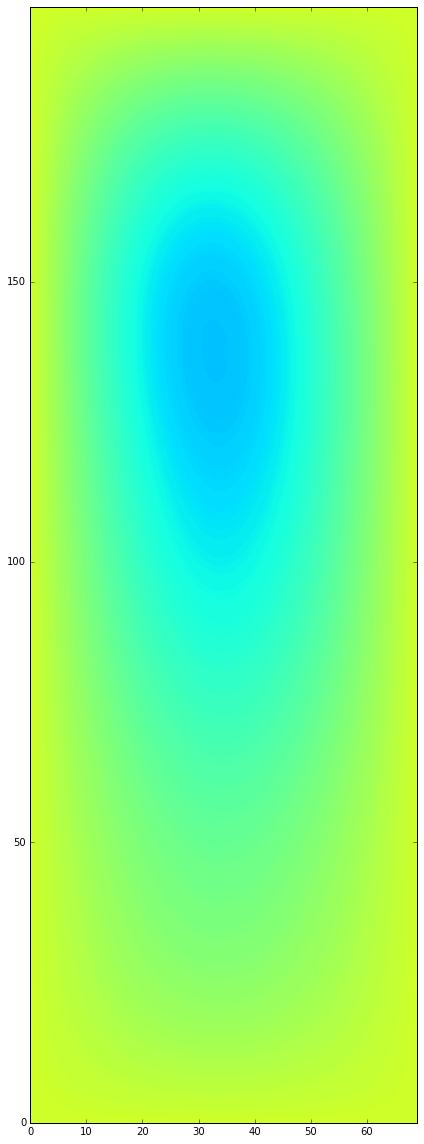

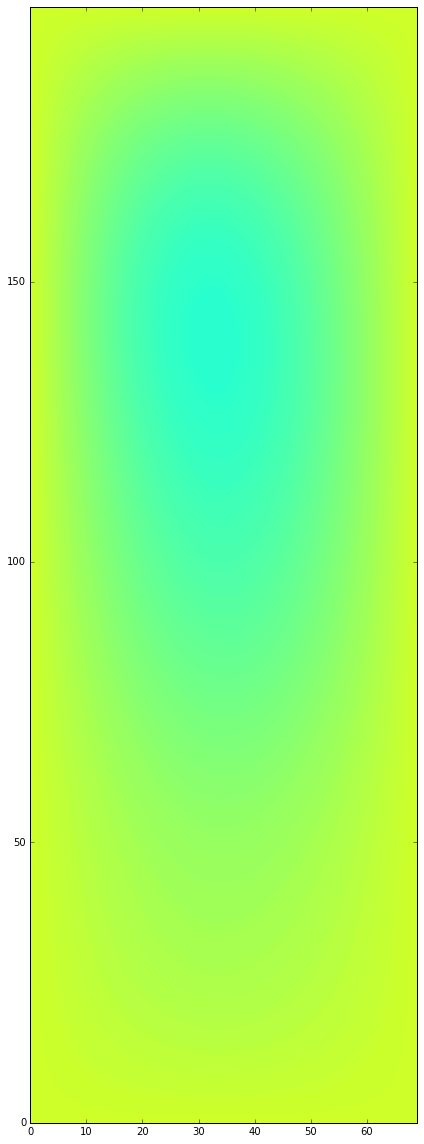

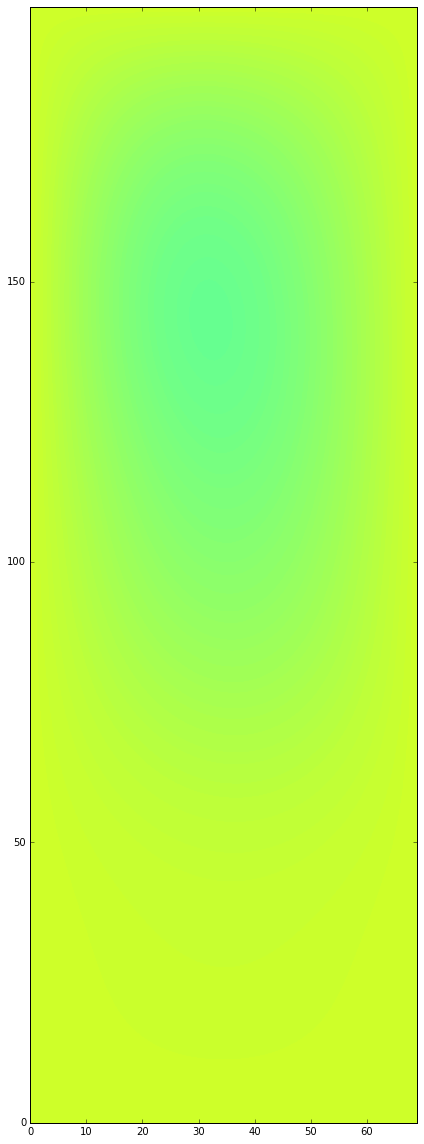

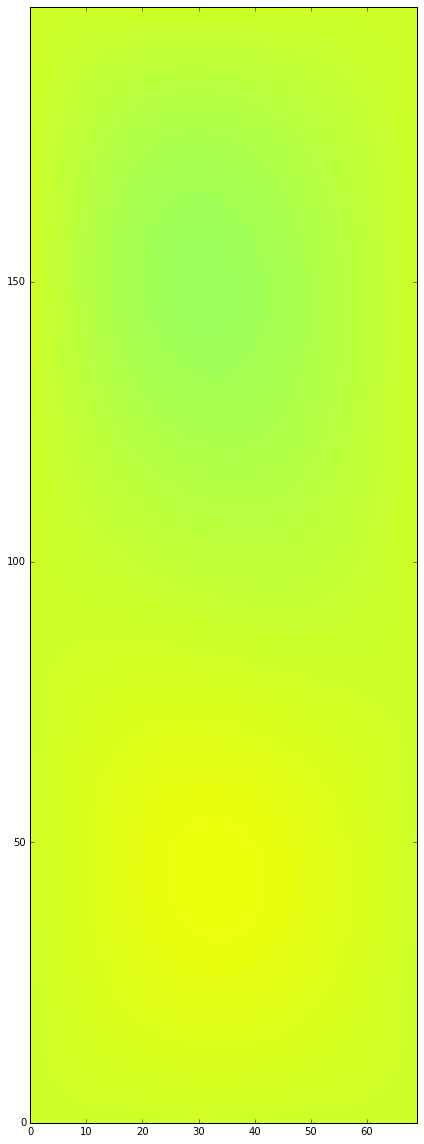

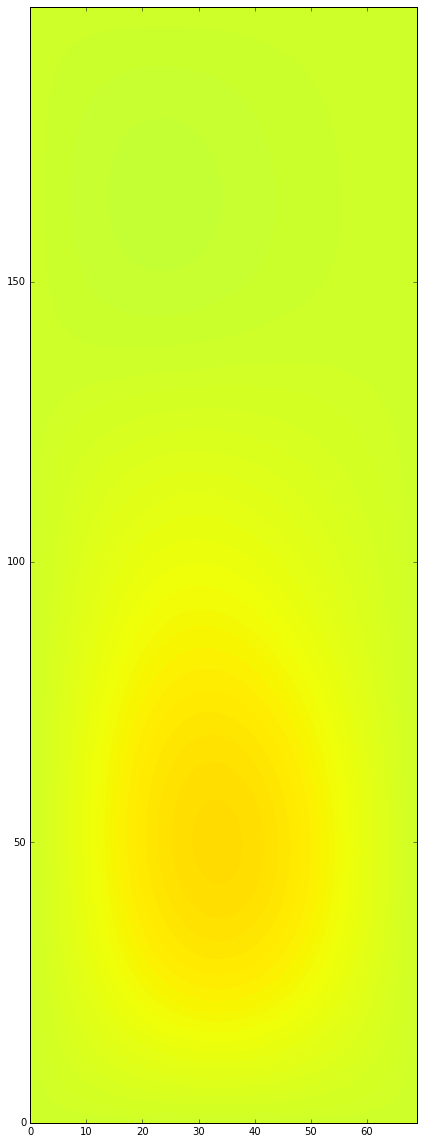

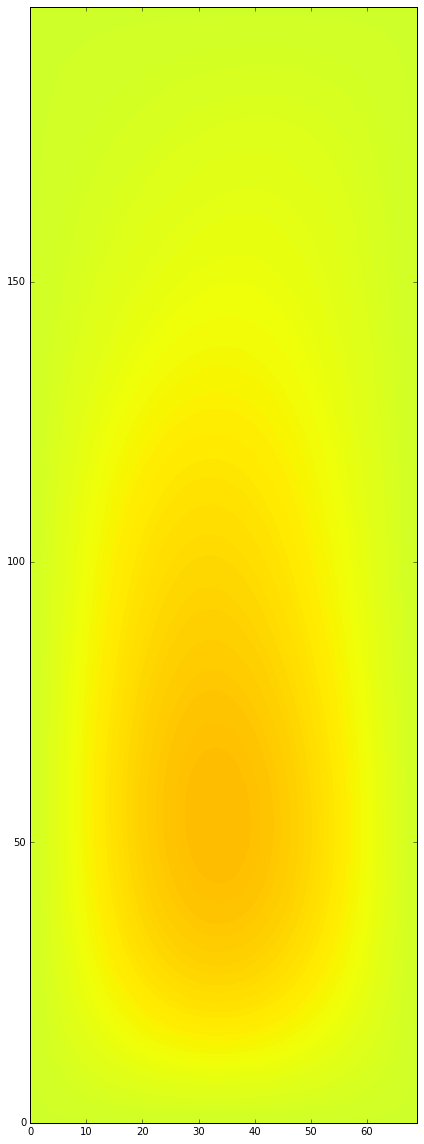

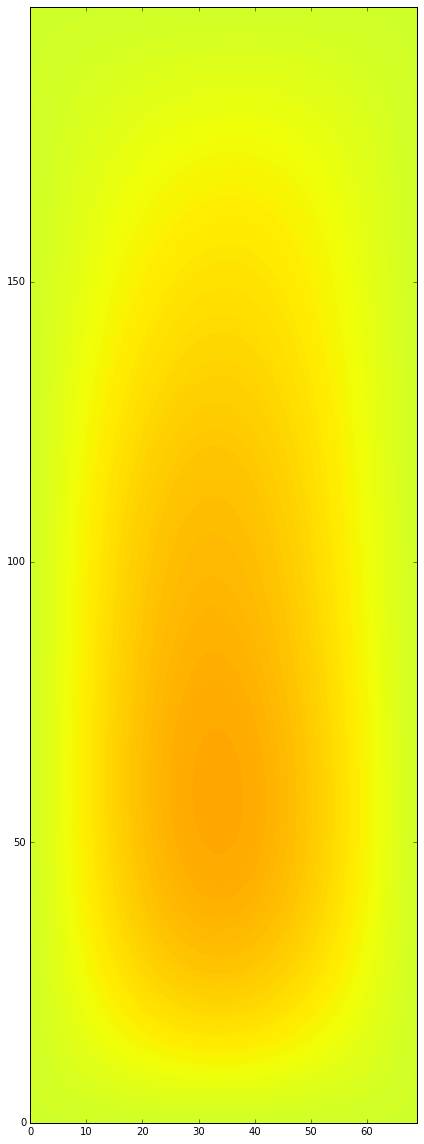

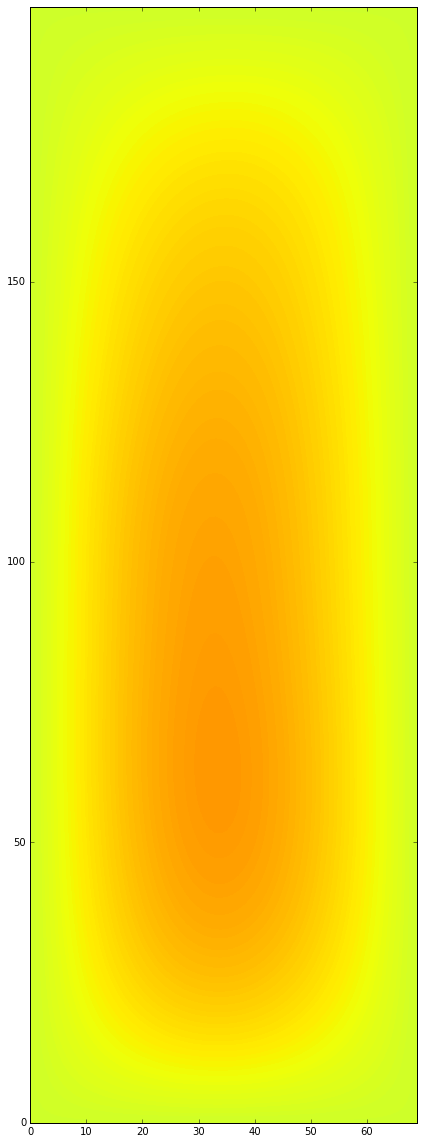

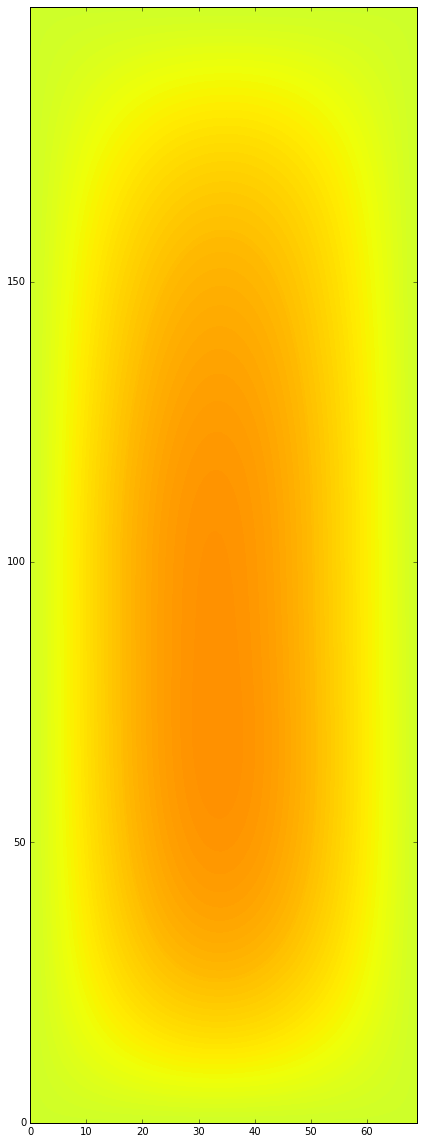

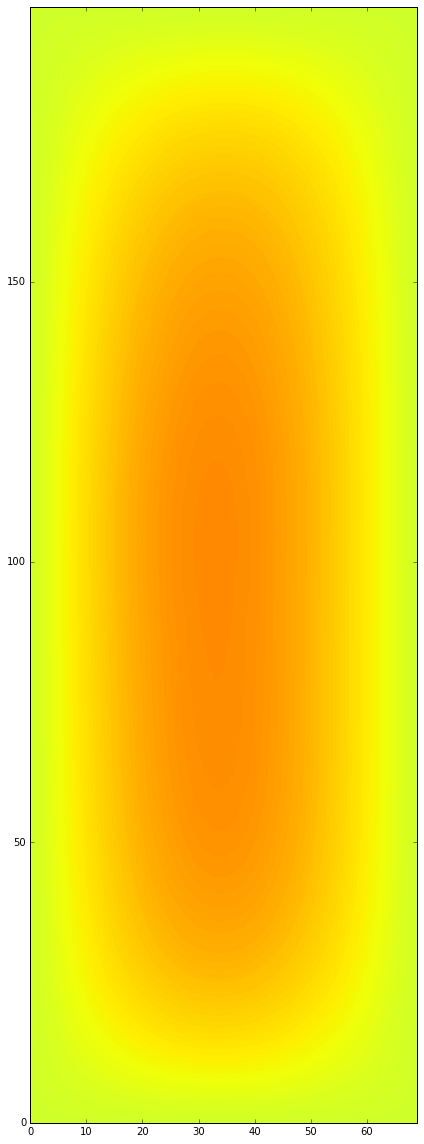

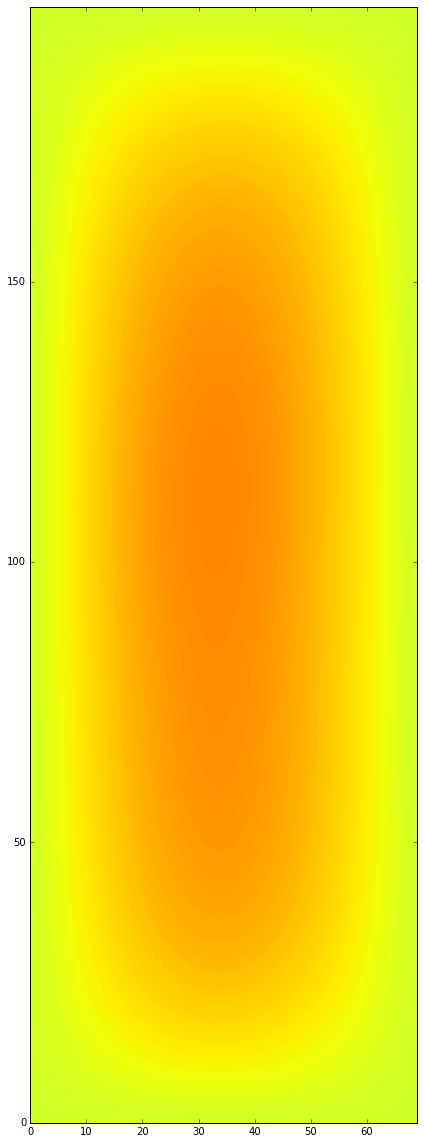

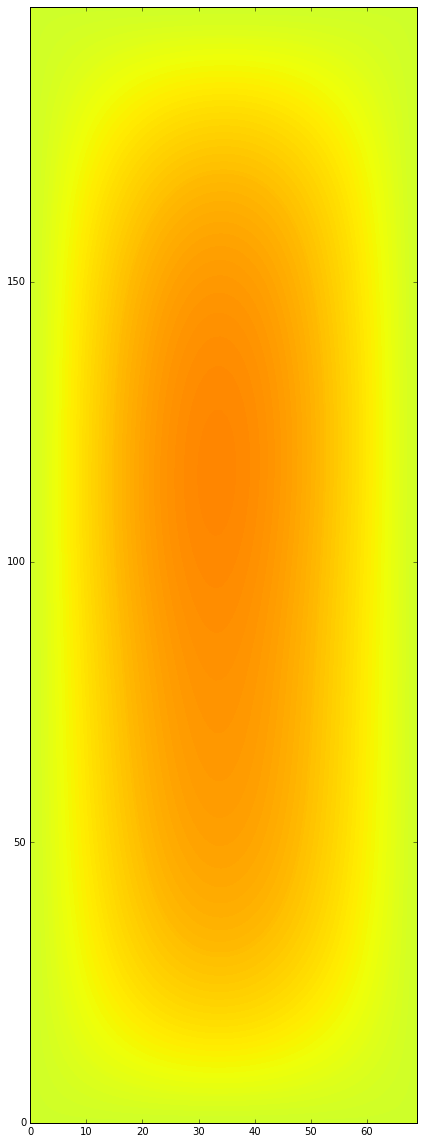

In [9]:
colorinterpolation = 100
colourMap = plt.cm.jet

for i in range(0,32):
    #fig,ax = plt.subplots(figsize=(6, 10))
    plt.figure(figsize=(20,20))
    plt.contourf(c[:,:,i],colorinterpolation, cmap=colourMap,vmin=-600,vmax=400)
    plt.axes().set_aspect('equal')
    
    #data = np.clip(np.random.randn(0, 0), -1, 1)
    #cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)
    #cbar = fig.colorbar(cax,ticks=[0,0.5,1],orientation='vertical')
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #plt.axis('off')
    #cbar=plt.colorbar(cax,ticks=[0,0.5,1])
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #cbar=plt.colorbar(cax,ticks=[0,0.5,1])
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #plt.axes().set_aspect('equal')
    #plt.xlim(0,70)
    #plt.ylim(0,200)
    
#plt.colorbar()
    plt.show()

In [28]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,16))
colorinterpolation = 100
#cbar=plt.colorbar(cax,ticks=[0,0.5,1])

def update(i):
    #im=c[:,:,i]*-1
    #im_normed = do_normalise(im)
    #im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    #im2 = undo_normalise(im_rotated)
    #cmap = mpl.cm.jet
   # norm = mpl.colors.Normalize(vmin=min(max_amplitude), vmax=max(max_amplitude))
    #ax.imshow(im)
    ax.contourf(np.negative(c[:,:,i]),colorinterpolation, cmap=cmap,vmin=np.min(c),vmax=np.max(c))
    #ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    #ax.set_axis_off()
    #data = np.clip(np.random.randn(0, 0), -1, 1)
    #cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)
    #cbar=plt.colorbar(cax,ticks=[0,0.5,1])
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #ax.xlim(0,70)
    #ax.ylim(0,200)

#cbar.ax.set_yticklabels(['Low','Medium','High'])

anim = FuncAnimation(fig, update, frames=np.arange(0, 32), interval=300)
anim.save('colour_rotation_invert_2.gif', dpi=150, writer='imagemagick')
plt.close()

/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


In [39]:
import matplotlib.animation as animation
print(animation.writers.list())

['imagemagick', 'imagemagick_file']


In [10]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,16))
colorinterpolation = 100
cmap = mpl.cm.jet
cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)
#cbar=plt.colorbar(cax,ticks=[0,0.5,1])
def init_func():
    ax.axes.set_aspect('equal')
    ax.set_xlim(0,70)
    ax.set_ylim(0,200)
    ax.set_axis_off()
    cbar=plt.colorbar(cax)#,ticks=[0,0.5,1])
    
def update(i):
    #im=np.negativec[:,:,i]
    #im_normed = do_normalise(im)
    #im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    #im2 = undo_normalise(im_rotated)
    #cmap = mpl.cm.jet
   # norm = mpl.colors.Normalize(vmin=min(max_amplitude), vmax=max(max_amplitude))
    #ax.imshow(im)
    ax.contourf(np.negative(c[:,:,i]),colorinterpolation, cmap=cmap,vmin=np.min(c),vmax=np.max(c))
    #ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    #ax.set_axis_off()
    #data = np.clip(np.random.randn(0, 0), -1, 1)
    #cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)
    #cbar=plt.colorbar(cax,ticks=[0,0.5,1])
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #ax.xlim(0,70)
    #ax.ylim(0,200)
anim = FuncAnimation(fig, update, frames=np.arange(0, 32),init_func=init_func, interval=300)
anim.save('colour_rotation_invert_3.gif', dpi=150, writer='imagemagick')
plt.close()

/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


In [15]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,16))
colorinterpolation = 100
cmap = mpl.cm.jet
data = np.clip(np.random.randn(0, 0), -1, 1)
cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)

def update(i):
    im=c[:,:,i]*-1
    #im_normed = do_normalise(im)
    #im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    #im2 = undo_normalise(im_rotated)
    #cmap = mpl.cm.jet
   # norm = mpl.colors.Normalize(vmin=min(max_amplitude), vmax=max(max_amplitude))
    #ax.imshow(im)
    ax.contourf(c[:,:,i],colorinterpolation, cmap=cmap,vmin=-500,vmax=400)
    #ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    #ax.set_axis_off()
    #data = np.clip(np.random.randn(0, 0), -1, 1)
    #cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)
cbar=plt.colorbar(cax,ticks=[0,0.5,1])
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #ax.xlim(0,70)
    #ax.ylim(0,200)

#fig, ax = plt.subplots()
#mat = ax.matshow(generate_data())
#plt.colorbar(mat)

anim = FuncAnimation(fig, update, frames=np.arange(0, 32), interval=300)
anim.save('colour_rotation_invert.gif', dpi=80, writer='imagemagick')
plt.close()

/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


In [6]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure(figsize=(7,20))
colorinterpolation = 100
c=np.load("waves.npy")
#cmap = mpl.cm.jet
#plt.figure(figsize=(20,20))
 #   plt.contourf(c[:,:,i],colorinterpolation, cmap=colourMap,vmin=-600,vmax=400)
  #  plt.axes().set_aspect('equal')

def update(i):
    #im=c[:,:,i]*-1
    #im_normed = do_normalise(im)
    #im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    #im2 = undo_normalise(im_rotated)
    #cmap = mpl.cm.jet
   # norm = mpl.colors.Normalize(vmin=min(max_amplitude), vmax=max(max_amplitude))
    #ax.imshow(im)
    if i<32:
        plt.contourf(np.negative(c[:,:,i]),colorinterpolation, cmap=mpl.cm.jet,vmin=np.min(c),vmax=np.max(c))
    else:
        img=c[:,:,0]
        img[:,:]=0
        plt.contourf(img[:,:],cmap=mpl.cm.gray)
        
    plt.axes().set_aspect('equal')
    plt.axis('off')
    #plt.colorbar()
    #data = np.clip(np.random.randn(0, 0), -1, 1)
    #cax = ax.imshow(data, interpolation='None', cmap=plt.cm.jet)
    #cbar=plt.colorbar(cax,ticks=[0,0.5,1])
    #cbar.ax.set_yticklabels(['Low','Medium','High'])
    #ax.xlim(0,70)
    #ax.ylim(0,200)
    #ax.axes().set_aspect('equal')
    #ax.x
    #plt.axes().set_aspect('equal')
    #ax.xlim(0,70)
    #ax.ylim(0,200)

anim = FuncAnimation(fig, update, frames=np.arange(0, 33))
anim.save('colour_rotation_test.gif', dpi=20, writer='imagemagick')
plt.close()

In [41]:
img = np.empty((200,70))

In [42]:
img[:,:]=0

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


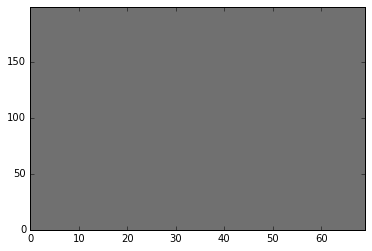

In [43]:
print(img)
plt.contourf(img[:,:],cmap=mpl.cm.gray)
plt.show()

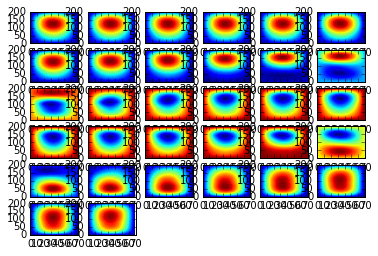

In [36]:
colorinterpolation = 100
colourMap = plt.cm.jet
for i in range(0,32):
    plt.subplot(6,6,i+1)
    plt.contourf(c[:,:,i],colorinterpolation, cmap=colourMap)
    #plt.axes().set_aspect('equal')
    plt.xlim(0,70)
    plt.ylim(0,200)
    
#plt.colorbar()
plt.show()

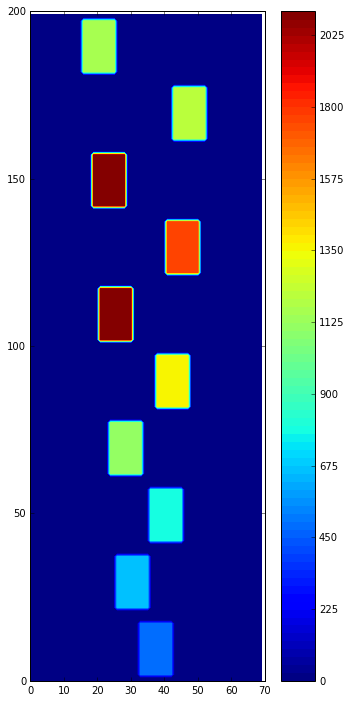

In [12]:

colorinterpolation = 100
colourMap = plt.cm.jet
            #plt.contourf(T, colorinterpolation, cmap=colourMap)
plt.figure(figsize=(6,12))
plt.contourf(c[:,:,1],colorinterpolation, cmap=colourMap)
plt.axes().set_aspect('equal')
plt.colorbar()
            #plt.axis('scaled')
            #plt.plot(coordinates(:,1), -coordinates(:,2))
            #plt.imshow(self.V[:,:,30],extent=(0, 100, 0, 100),origin =[0,0])
            #imshow(np.asarray(self.V))
plt.xlim(0,70)
plt.ylim(0,200)
plt.show()

In [101]:
g = np.loadtxt('good.out')
m = np.loadtxt('mua.out')
g.shape[1]

32

TESTES

In [ ]:
colorinterpolation = 100
            colourMap = plt.cm.jet
            #plt.contourf(T, colorinterpolation, cmap=colourMap)
            plt.figure(figsize=(6,12))
            plt.contourf(self.V[:,:,30],colorinterpolation, cmap=colourMap)
            plt.axes().set_aspect('equal')
            plt.colorbar()
            #plt.axis('scaled')
            #plt.plot(coordinates(:,1), -coordinates(:,2))
            #plt.imshow(self.V[:,:,30],extent=(0, 100, 0, 100),origin =[0,0])
            #imshow(np.asarray(self.V))
            plt.xlim(0,70)
            plt.ylim(0,200)
            plt.show()

[[ 180.  160.  140.  120.  100.   80.   60.   40.   20.    0.]]
19.0 10.0


/home/harison/miniconda3/envs/phy/lib/python3.5/site-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


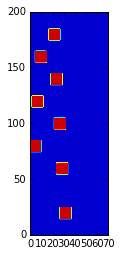

(200, 70, 32)

In [38]:
mm  = MicroMatrix(geometry=geometry)
a=mm.get_matrix(waves)
a.shape

In [9]:
a=np.array([ 22,10,24.5,7.5 , 27. ,   5. ,  29.5,   2.5,  32. ,   0. ])
x_offset=a[0]
x_scale=4
#x_offset=22.
waveform_size=32
x=x_scale*x_offset+range(0,waveform_size)
x

array([  88.,   89.,   90.,   91.,   92.,   93.,   94.,   95.,   96.,
         97.,   98.,   99.,  100.,  101.,  102.,  103.,  104.,  105.,
        106.,  107.,  108.,  109.,  110.,  111.,  112.,  113.,  114.,
        115.,  116.,  117.,  118.,  119.])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]
aaa


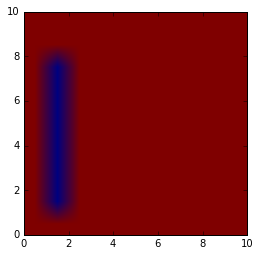

In [11]:
from matplotlib.pyplot import imshow
b=np.zeros((10,10))
b[1:8,1:2]=1
print(b)
b=b*-1
print(b)
if b[0,0] is not 0:
    print("aaa")
imshow(b,extent=(0, 10, 0, 10),origin =[0,0])

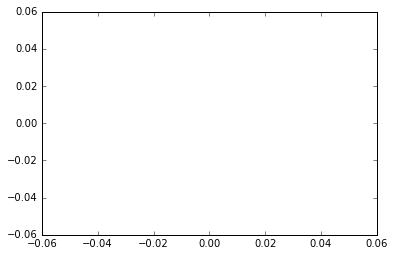

In [56]:
plt.plot(b[:,0],b[0,:])

In [7]:
import numpy as np
a=[ 22. ,  10. ,  24.5  , 7.5 , 27.   , 5.  , 29.5  , 2.5,  32. ,   0. ]
b=[ 180. , 160.,  140. , 120.  ,100. ,  80. ,  60.   ,40. ,  20.  ,  0.]
c=np.matrix([a,b])
print(c)

[[  22.    10.    24.5    7.5   27.     5.    29.5    2.5   32.     0. ]
 [ 180.   160.   140.   120.   100.    80.    60.    40.    20.     0. ]]


In [ ]:
geometry = np.matrix([[ 22. ,  10. ,  24.5  , 7.5 , 27.   , 5.  , 29.5  , 2.5,  32. ,   0. ],
                    [ 180. , 160.,  140. , 120.  ,100. ,  80. ,  60.   ,40. ,  20.  ,  0.]])